In [2]:
# import system packages
import os
from datetime import datetime
import sys
import argparse
import traceback
import pickle
import yaml

# import numpy
import numpy as np
import healpy as hp
%matplotlib inline
import pylab as plt

# the MPI comunicator class, customized for pycal data storage
from pycal.mpi import get_world, Comm

# the Data class 
from pycal.dist import distribute_uniform, Data

# some pycal utils to share informations with the environment
from pycal.utils import Logger, Environment, memreport

# some timers
from pycal.timing import function_timer, GlobalTimers, Timer, gather_timers
from pycal.timing import dump as dump_timing

# the simulate the pointing, the atmosphere and put all the information in the TODGround class
from pycal.todmap import TODGround, OpSimAtmosphere, OpPointingHpix
from pycal.weather import Weather

# Some wrapper to libaatm, they solve the radiative transfer equation in local thermodynamic equilibrium
from pycal.todmap.atm import atm_absorption_coefficient, atm_absorption_coefficient_vec

# helper functions
from pycal.tests._helpers import boresight_focalplane
import pycal.qarray as qa

# focal plane and telescope calsses
from pycal.todmap import Focalplane
from pycal.todmap import Telescope

In [3]:
# we start to load a fake focal plane. In this way it is possible to see the structure of the Focalplane class

def load_focalplane(args, comm):
    focalplane = None

    # Load focalplane information

    if comm.comm_world is None or comm.comm_world.rank == 0:
        if args.focalplane is None:
            detector_data = {}
            with open(r'/opt/scratch/pycal_simulations/strip_focal_plane.yaml') as file:
                focalplane=yaml.full_load(file)

            detecotrs=focalplane['horns'].keys()
            for i in detecotrs:
                directions=focalplane['horns'][i]['orientation']
                l=np.arctan(directions[0]/directions[2])
                u=np.arctan(directions[1]/directions[2])
                zaxis = np.array([0, 0, 1], dtype=np.float64)
                
                angrot = qa.rotation(zaxis, 0 * np.pi / 180.0)
                wx = np.rad2deg(l) * np.pi / 180.0
                wy = np.rad2deg(u) * np.pi / 180.0
                wz = np.sqrt(1.0 - (wx * wx + wy * wy))
                wdir = np.array([wx, wy, wz])
                strip_quat = qa.from_vectors(zaxis, wdir)
                
                strip = {}
                strip["quat"] = strip_quat
                strip["fwhm"] = 20.0
                strip["fknee"] = 0.0
                strip["fmin"] = 1e-9
                strip["alpha"] = 1.0
                strip["NET"] = 1.0
                strip["color"] = "r"
            
                detector_data[i] = strip
            
            focalplane = Focalplane(
                detector_data=detector_data, sample_rate=args.sample_rate
            )
        else:
            focalplane = Focalplane(
                fname_pickle=args.focalplane, sample_rate=args.sample_rate
            )
    if comm.comm_world is not None:
        focalplane = comm.comm_world.bcast(focalplane, root=0)

    if args.debug:
        if comm.comm_world is None or comm.comm_world.rank == 0:
            outfile = "{}/focalplane.png".format(args.outdir)
            focalplane._plot_fp(12, 12, outfile)

    #schedule.telescope.focalplane = focalplane
    #detweights = focalplane.detweights

    return focalplane

In [4]:
# definition of the logger, the global timer and the environment
log = Logger.get()
gt = GlobalTimers.get()
env = Environment.get()

gt.start("Atmospheric simulation (globbal timer)")
timer0 = Timer()
timer0.start()

# Get the communicator
mpiworld, procs, rank = get_world()
if rank == 0:
    print(env)
if mpiworld is None:
    log.info("Running serially with one process at {}".format(str(datetime.now())))
else:
    if rank == 0:
        log.info(
            "Running with {} processes at {}".format(procs, str(datetime.now()))
        )
comm = Comm(world=mpiworld)

<cal.Environment
  Source code version = 0.0.0
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 16
  MPI build enabled
  MPI runtime enabled
>


In [5]:
# Arguments of the simulation
class args:
    sample_rate=20
    focalplane=None
    ces_name = "Test1"
    scan="spin"
    subscan="spin_1day"
    ces_stop_time = 400
    ces_start_time = 0
    sample_rate = 20
    site_name= "Tenerife"
    site_lon = "-16:31:00"
    site_lat = "28:20:00"
    site_alt = 2390.0
    coord = "C"
    ces_azmin = 10
    ces_azmax = 179
    ces_el = 70
    scanrate = 1.0
    scan_accel = 3.0
    CES_start = None
    NSIDE=256
    debug=True
    outdir="out_directory"
args = args()

In [6]:
fp = load_focalplane(args, comm)

# STRIP focalplane from the instrumental db files

In [7]:
%matplotlib inline

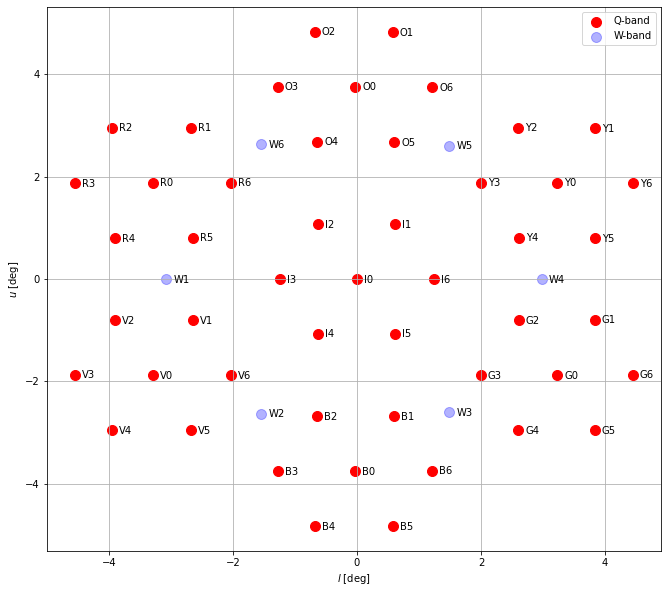

In [17]:
with open(r'/opt/scratch/pycal_simulations/strip_focal_plane.yaml') as file:
    focalplane=yaml.full_load(file)
detecotrs=focalplane['horns'].keys()

plt.figure(figsize=(11, 10))

for i in detecotrs:
    directions=focalplane['horns'][i]['orientation']
    #print(i, directions)
    l=np.arctan(directions[0]/directions[2])
    u=np.arctan(directions[1]/directions[2])
    if np.shape(i.split('W'))[0] == 1:
        if i == "I0":
            plt.scatter(np.rad2deg(l), np.rad2deg(u), s=100, marker="o", color='r', label="Q-band")
        else:
            plt.scatter(np.rad2deg(l), np.rad2deg(u), s=100, marker="o", color='r')
        plt.text(np.rad2deg(l+0.002), np.rad2deg(u-0.0012), i)
    else:
        if i == "W1":
            plt.scatter(np.rad2deg(l), np.rad2deg(u), s=100, marker="o", color='b', alpha=0.3, label="W-band")
        else:
            plt.scatter(np.rad2deg(l), np.rad2deg(u), s=100, marker="o", color='b', alpha=0.3)
        plt.text(np.rad2deg(l+0.002), np.rad2deg(u-0.0012), i)
plt.xlabel("$l$ [deg]")
plt.ylabel("$u$ [deg]")
plt.legend()
plt.grid()


In [17]:
ZAX = np.array([0,0,1])
v02 = np.array([-0.0118612457584, 0.0842200444514, 0.996376582905])
buf=np.zeros(4)

In [18]:
quat = qa.from_vectors(ZAX, v02)

In [19]:
print(np.rad2deg(l), np.rad2deg(u))

-1.5419961465759136 2.6363310416552364


In [20]:
np.rad2deg(qa.to_position(quat2))

NameError: name 'quat2' is not defined

In [21]:
centers = list()
zaxis = np.array([0, 0, 1], dtype=np.float64)
angrot = qa.rotation(zaxis, 1 * np.pi / 180.0)
wx = 1 * np.pi / 180.0
wy = 2 * np.pi / 180.0
wz = np.sqrt(1.0 - (wx * wx + wy * wy))
wdir = np.array([wx, wy, wz])
posrot = qa.from_vectors(zaxis, wdir)

print(posrot)

[-0.01745662  0.00872831  0.          0.99980952]
